# Identify user's affiliation with IBM
Author: Daheng Wang  
Last modified: 2017-05-28

# Roadmap
1. Tag native tweets for keyword 'ibm' in 'text' field (multiprocessing)
2. Aggreate number of tweets and number of IBM tweets for each user
3. Identify affiliation based on the proportion of IBM tweets

# Steps

In [1]:
"""
Initialization
"""

'''
Data analysis modules: pandas, matplotlib, numpy, and etc
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

'''
Standard modules, MongoDB modules
''' 
import os, sys, json, datetime, pickle, multiprocessing, logging
from pprint import pprint

import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING

'''
Custom tool modules
'''
import mongodb  # module for setting up connection with (local) MongoDB database
import multiprocessing_workers  # module for splitting workloads between processes
import utilities  # module for various custom utility functions
from config import * # import all global configuration variables

'''
Misc
'''
NB_NAME = '20170504-user_affiliation_2'

## Tag native tweets for keyword 'ibm' in 'text' field (multiprocessing)

In [6]:
%%time
"""
Use multiprocessing to tag the 'text' field of native tweets for keyword 'ibm'
Worker function 'worker_tag_kws_in_tw' is wrapped in multiprocessing_workers.py
"""
if 0 == 1:
    multiprocessing.log_to_stderr(logging.DEBUG)
    
    procedure_name = 'tag_{}_text_ibm'.format(TW_NT_COL)
    kw_lst = ['ibm']
    process_n = multiprocessing.cpu_count() - 1 # set processes number to CPU numbers minus 1
    suffix = 'json'
    inter_files = utilities.gen_inter_filenames_list(NB_NAME, procedure_name, process_n, suffix)
    
    jobs = []
    for batch_i in range(process_n):
        p = multiprocessing.Process(target=multiprocessing_workers.worker_tag_kws_in_tw,
                                    args=(DB_NAME, TW_NT_COL, batch_i, process_n, inter_files[batch_i], kw_lst),
                                    name='Process-{}/{}'.format(batch_i, process_n))
        jobs.append(p)
    
    for job in jobs:
        job.start()
        
    for job in jobs:
        job.join()

[INFO/Process-0/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-1/11] child process calling self.run()


Process0/11 handling documents 0 to 528437...


[INFO/Process-3/11] child process calling self.run()
[INFO/Process-2/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-4/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-5/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-6/11] child process calling self.run()
[INFO/Process-7/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-8/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-9/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-10/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
Process1/11 handling documents 528438 to 1056875...
Process2/11 handling documents 1056876 to 1585313...
Process3/11 handling documents 1585314 to 2113751...
Process4/11 handling documents 2113752 to 2642189...
Process5/11 handling documents 2642190 to 3170627...
Process6/11 handling documents 3170628 to 3699065...
Process7/11 handling documents 3699066 to 4227503...
Process8/11 handling documents 4227504 to 4755941...
Process9/11 handling documents 4755942 to 5284379...
Process10/11 handling documents 5284380 to 5812824...


[INFO/Process-0/11] process shutting down
[DEBUG/Process-0/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-0/11] running the remaining "atexit" finalizers
[INFO/Process-0/11] process exiting with exitcode 0
[INFO/Process-1/11] process shutting down
[DEBUG/Process-1/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-1/11] running the remaining "atexit" finalizers
[INFO/Process-1/11] process exiting with exitcode 0
[INFO/Process-2/11] process shutting down
[DEBUG/Process-2/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-2/11] running the remaining "atexit" finalizers
[INFO/Process-2/11] process exiting with exitcode 0
[INFO/Process-3/11] process shutting down
[DEBUG/Process-3/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-3/11] running the remaining "atexit" finalizers
[INFO/Process-3/11] process exiting with exitcode 0
[INFO/Process-4/11] process shutting down
[DEBUG/Process-4/11] running all "atexit" 

CPU times: user 348 ms, sys: 688 ms, total: 1.04 s
Wall time: 14min 9s


In [2]:
%%time
"""
Build a new collection for keyword 'ibm' tag on 'text' field of native tweets
Register in config:
    TW_NT_TXT_IBM_TAG_COL
"""
if 0 == 1:
    procedure_name = 'tag_{}_text_ibm'.format(TW_NT_COL)
    kw_lst = ['ibm']
    process_n = multiprocessing.cpu_count() - 1 # set processes number to CPU numbers minus 1
    suffix = 'json'
    inter_files = utilities.gen_inter_filenames_list(NB_NAME, procedure_name, process_n, suffix)

    tw_nt_txt_ibm_tag_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_TXT_IBM_TAG_COL)
    for inter_file in inter_files:
        print('Reading {}...'.format(inter_file), end=' ')
        lines = open(inter_file).readlines()
        parsed_jsons = [json.loads(line) for line in lines]
        print('Importing into {}.{}...'.format(DB_NAME, TW_NT_TXT_IBM_TAG_COL))
        tw_nt_txt_ibm_tag_col.insert_many(parsed_jsons)
    print('Done')

MongoDB on localhost:27017/tweets_ek-2.tw_nt_txt_ibm_tag connected successfully!
Reading ./tmp/20170504-user_affiliation_2-tag_tw_nt_text_ibm-0.json... Importing into tweets_ek-2.tw_nt_txt_ibm_tag...
Reading ./tmp/20170504-user_affiliation_2-tag_tw_nt_text_ibm-1.json... Importing into tweets_ek-2.tw_nt_txt_ibm_tag...
Reading ./tmp/20170504-user_affiliation_2-tag_tw_nt_text_ibm-2.json... Importing into tweets_ek-2.tw_nt_txt_ibm_tag...
Reading ./tmp/20170504-user_affiliation_2-tag_tw_nt_text_ibm-3.json... Importing into tweets_ek-2.tw_nt_txt_ibm_tag...
Reading ./tmp/20170504-user_affiliation_2-tag_tw_nt_text_ibm-4.json... Importing into tweets_ek-2.tw_nt_txt_ibm_tag...
Reading ./tmp/20170504-user_affiliation_2-tag_tw_nt_text_ibm-5.json... Importing into tweets_ek-2.tw_nt_txt_ibm_tag...
Reading ./tmp/20170504-user_affiliation_2-tag_tw_nt_text_ibm-6.json... Importing into tweets_ek-2.tw_nt_txt_ibm_tag...
Reading ./tmp/20170504-user_affiliation_2-tag_tw_nt_text_ibm-7.json... Importing into 

In [4]:
"""
Build compound index 'user_id'-'id' on new colleciton
"""
if 0 == 1:
    tw_nt_txt_ibm_tag_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_TXT_IBM_TAG_COL)
    index_lst = [('user_id', pymongo.ASCENDING),
                 ('id', pymongo.ASCENDING)]
    print('Building compond index {}...'.format(index_lst))
    tw_nt_txt_ibm_tag_col.create_index(keys=index_lst)
    print('Done')

MongoDB on localhost:27017/tweets_ek-2.tw_nt_txt_ibm_tag connected successfully!
Building compond index [('user_id', 1), ('id', 1)]...
Done


In [3]:
"""
Check how many native tweets are tagged as having 'ibm' keyword in 'text' field
"""
if 0 == 1:
    tw_nt_txt_ibm_tag_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_TXT_IBM_TAG_COL)

    tw_nt_num = tw_nt_txt_ibm_tag_col.count()

    tw_nt_txt_ibm_num = tw_nt_txt_ibm_tag_col.count(filter={'X_0': {'$eq': True}})
    print('Native tweets tagged as having "ibm" keyword: {} ({:.2%} out of total) '.format(tw_nt_txt_ibm_num, tw_nt_txt_ibm_num / tw_nt_num))

MongoDB on localhost:27017/tweets_ek-2.tw_nt_txt_ibm_tag connected successfully!
Native tweets tagged as having "ibm" keyword: 152526 (2.62% out of total) 


## Aggreate number of tweets and number of IBM tweets for each user

Aggregate information into list of dictionaries. Example:  
```{'user_id': id of the user,
   'tweets_num': number of tweets (native) authored by the user,
   'ibm_tweets_num': number of IBM tweets (native) authored by the user}```

In [2]:
"""
Aggreate 'tweets_num' and 'ibm_tweets_num' for each user and write to tmp pickle
"""

user_tw_ibmtw_num_lst_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'user_tw_ibmtw_num.lst.pkl'))

if 0 == 1:
    print("Building pickle from database...")
    data_lst = []
    
    group_dict = {'$group': {'_id': '$user_id',                            
                             'tweets_num': {'$sum': 1},
                             'ibm_tweets_num': {'$sum': {'$cond': ['$X_0', 1, 0]}}}} # if 'X_0' is true, add count for IBM tweets
    
    project_dict = {'$project': {'_id': 0,
                                'user_id': '$_id',
                                'tweets_num': 1,
                                'ibm_tweets_num': 1}}
    
    ppl_lst = [group_dict, project_dict]
    print('Aggreating on collection "{}"'.format(TW_NT_TXT_IBM_TAG_COL))
    tw_nt_ibm_tag_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_TXT_IBM_TAG_COL)
    cursor = tw_nt_ibm_tag_col.aggregate(pipeline=ppl_lst,
                                         allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    
    for doc in cursor:
        data_lst.append(doc)
    
    with open(user_tw_ibmtw_num_lst_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')

## Identify affiliation based on the proportion of IBM tweets

### Plot the proportion of IBM tweets against number of tweets

In [3]:
"""
Load pickled data
"""
if 1 == 1:
    data_lst = []
    with open(user_tw_ibmtw_num_lst_pkl, 'rb') as f:
        data_lst = pickle.load(f)
        
    df_user_nt = pd.DataFrame(data=data_lst,
                              columns=['user_id', 'tweets_num', 'ibm_tweets_num'], # explicitly pass in names of columns
                              dtype=int)

    # compute the proportion of IBM tweets
    df_user_nt['ibm_tweets_prop'] = df_user_nt['ibm_tweets_num'] / df_user_nt['tweets_num']

In [4]:
pcls = np.arange(start=0.1, stop=1, step=0.1)
df_user_nt.describe()

,user_id,tweets_num,ibm_tweets_num,ibm_tweets_prop
count,6.097990e+05,609799.000000,609799.000000,609799.000000
mean,1.270391e+17,9.532361,0.250125,0.035454
std,2.916200e+17,270.614078,5.039367,0.165439
min,2.100000e+01,1.000000,0.000000,0.000000
25%,9.299435e+07,1.000000,0.000000,0.000000
50%,5.124867e+08,1.000000,0.000000,0.000000
75%,3.025774e+09,3.000000,0.000000,0.000000
max,8.658630e+17,73417.000000,1330.000000,1.000000


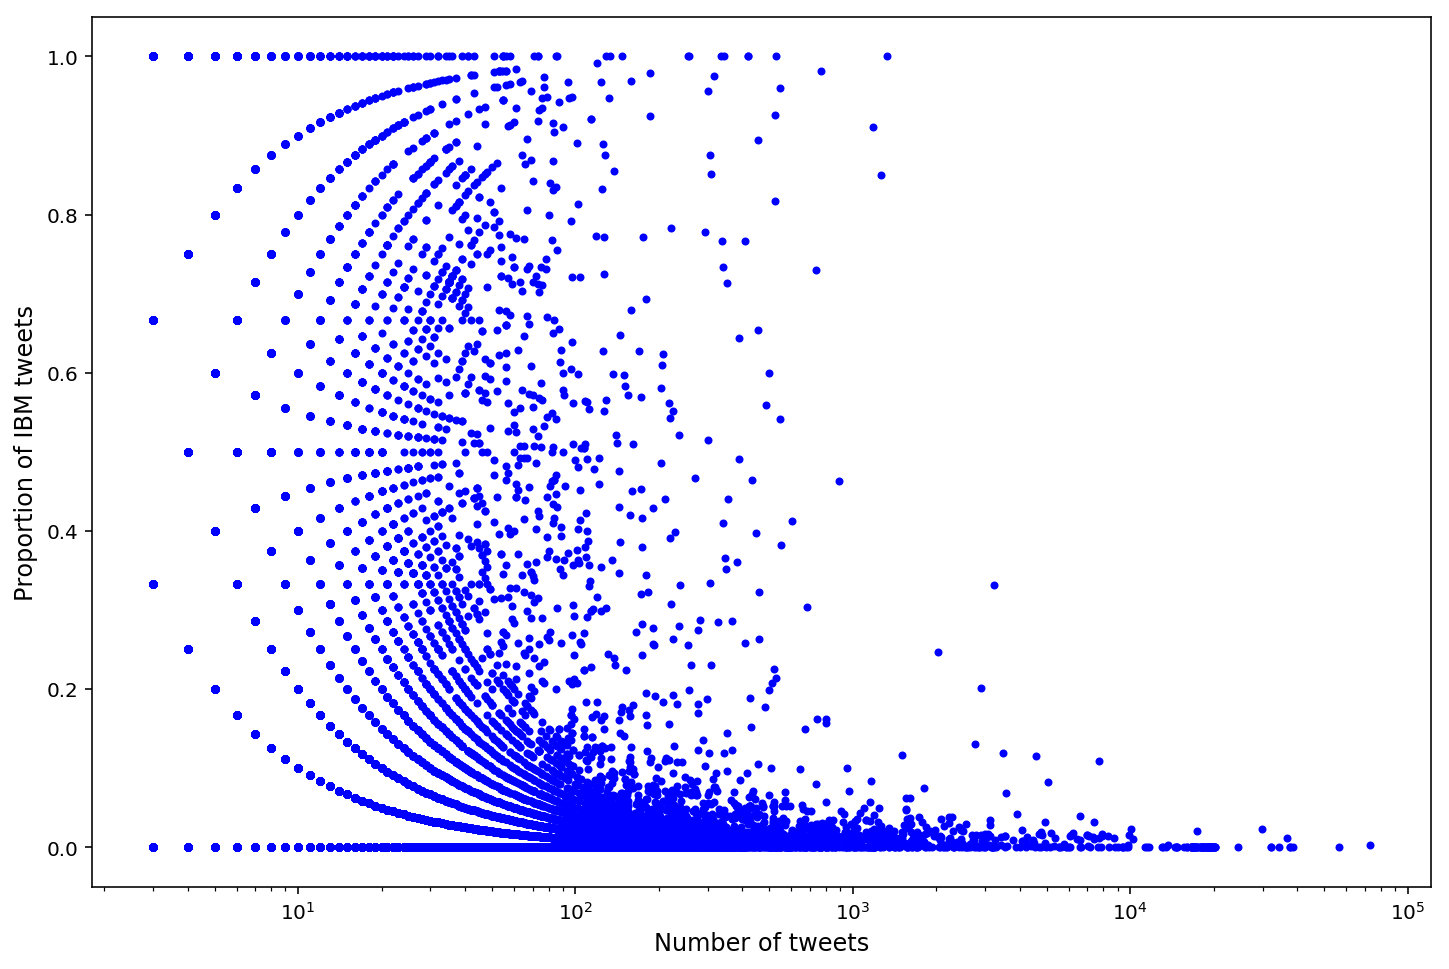

In [9]:
"""
Plot the proportion of IBM tweets against number of tweets
"""

ibm_tweets_prop_fig = os.path.join(FIG_DIR, 'ibm_tweets_prop.png')

if 1 == 1:
    '''
    Prepare data
    '''
    # set minimum tweets_num so ibm_tweets_prop would be meaningful
    df_tmp = df_user_nt[df_user_nt['tweets_num'] >= 3] 
    
    X = df_tmp['tweets_num']
    Y = df_tmp['ibm_tweets_prop']
    
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(12, 8))
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    # ax.set_title('Proportion of IBM tweets', fontdict=title_fontdict)
    
    label_fontdict = {'size': 'large'}
    ax.set_xlabel('Number of tweets', fontdict=label_fontdict)
    ax.set_ylabel('Proportion of IBM tweets', fontdict=label_fontdict)

#     plt.axvline(x=6, color='g')
#     plt.axhline(y=0.0475, color='g')
#     plt.axhline(y=0.2, color='g')
    
    plt.xscale('log')
#     plt.yscale('log')
    plt.plot(X, Y ,'b.')

    '''
    Save figure
    '''
    plt.savefig(ibm_tweets_prop_fig, dpi=200)

### Identifying affiliation with different combinations of (ibm_tweets_num, ibm_tweets_prop)

We are looking for users:
1. ~~with _reasonable_ 'tweets_num' value. So the 'ibm_tweets_prop' value would be meaningful.~~ ??
2. with _high_ 'ibm_tweets_prop' value, which means the user frequently mentions keyword 'ibm' in her tweets

In [5]:
"""
Load in IBM/non-IBM users identified by 'descritption' field.
Check the differences of 'ibm_tweets_num' and 'ibm_tweets_prop' between them
"""
if 1 == 1:
    '''
    Load pickled data
    '''
    user_nt_ibm_desc_ids_lst = []
    with open(USER_NT_IBM_DESC_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_desc_ids_lst = pickle.load(f)
    print('List length: "{}"'.format(len(user_nt_ibm_desc_ids_lst)))
    
    user_nt_nonibm_desc_ids_lst = []
    with open(USER_NT_NONIBM_DESC_IDS_LST_PKL, 'rb') as f:
        user_nt_nonibm_desc_ids_lst = pickle.load(f)
    print('List length: "{}"'.format(len(user_nt_nonibm_desc_ids_lst)))
    
    '''
    Subset users
    '''
    user_nt_ibm_desc_cond = df_user_nt['user_id'].isin(user_nt_ibm_desc_ids_lst)
    user_nt_nonibm_desc_cond = df_user_nt['user_id'].isin(user_nt_nonibm_desc_ids_lst)
    
    df_user_nt_ibm_desc = df_user_nt[user_nt_ibm_desc_cond]
    df_user_nt_nonibm_desc = df_user_nt[user_nt_nonibm_desc_cond]

List length: "6271"
List length: "603528"


Check distribution the of 'tweets_num', 'ibm_tweets_num', and 'ibm_tweets_prop'

In [6]:
"""
IBM users identified based on 'description' field
"""
df_user_nt_ibm_desc.describe()
# np.arange(start=0.1, stop=1, step=0.1)

,user_id,tweets_num,ibm_tweets_num,ibm_tweets_prop
count,6.271000e+03,6271.000000,6271.000000,6271.000000
mean,5.613556e+16,12.924573,6.526232,0.544841
std,2.025977e+17,44.555510,27.772399,0.396684
min,1.142600e+04,1.000000,0.000000,0.000000
25%,6.557586e+07,1.000000,1.000000,0.063002
50%,3.890683e+08,3.000000,1.000000,0.562500
75%,2.351117e+09,8.000000,4.000000,1.000000
max,8.652010e+17,1330.000000,1330.000000,1.000000


In [7]:
"""
non-IBM users identified based on 'description' field
"""
df_user_nt_nonibm_desc.describe()
# np.arange(start=0.1, stop=1, step=0.1)

,user_id,tweets_num,ibm_tweets_num,ibm_tweets_prop
count,6.035280e+05,603528.000000,603528.000000,603528.000000
mean,1.277758e+17,9.497114,0.184913,0.030161
std,2.923126e+17,271.978230,4.151206,0.152629
min,2.100000e+01,1.000000,0.000000,0.000000
25%,9.338949e+07,1.000000,0.000000,0.000000
50%,5.152529e+08,1.000000,0.000000,0.000000
75%,3.032748e+09,3.000000,0.000000,0.000000
max,8.658630e+17,73417.000000,1074.000000,1.000000


We can see that, for IBM/non-IBM users identified based on their 'description' field
1. IBM users have slightly higher 'tweets_num'.
2. IBM users have significantly higher 'ibm_tweets_num' and 'ibm_tweets_prop'

This means 'ibm_tweets_num'/'ibm_tweets_prop' can be used to identify IBM users as a supplement of the 'description' field based method

### Different conditions

We set three identification conditions:  
1. Cond1: mimimal requirements ('ibm_tweets_num' >= 1)
2. Cond2: IBM tweets prop >= first quartile ('ibm_tweets_prop' >= 0.063002)
3. Cond3: IBM tweets prop >= median ('ibm_tweets_prop' >= 0.562500)

**Note**: To make 'ibm_tweets_prop' value meaningful and not affected by large amount of users with few tweets, we set 'tweets_num' >= 3, which is the median of 'tweets_num' of IBM users from 'description' field based method.

In [9]:
df_user_nt[df_user_nt['tweets_num'] >= 3].describe(np.arange(0.1, 1, 0.1))

,user_id,tweets_num,ibm_tweets_num,ibm_tweets_prop
count,1.652300e+05,165230.00000,165230.000000,165230.000000
mean,1.274254e+17,31.92551,0.814047,0.043241
std,2.912718e+17,519.21419,9.652073,0.147294
min,2.240000e+02,3.00000,0.000000,0.000000
10%,1.952032e+07,3.00000,0.000000,0.000000
20%,5.059656e+07,3.00000,0.000000,0.000000
30.0%,1.245414e+08,4.00000,0.000000,0.000000
40%,2.639151e+08,5.00000,0.000000,0.000000
50%,5.093023e+08,6.00000,0.000000,0.000000
60%,1.399440e+09,7.00000,0.000000,0.000000


In [10]:
"""
Users with >=3 tweets and >=1 IBM tweets
"""
user_nt_ibm_tw_prop_cond1 = (df_user_nt['ibm_tweets_num'] >= 1) & (df_user_nt['tweets_num'] >= 3)
df_user_nt_ibm_tw_prop_1 = df_user_nt[user_nt_ibm_tw_prop_cond1]
df_user_nt_ibm_tw_prop_1.describe()

,user_id,tweets_num,ibm_tweets_num,ibm_tweets_prop
count,2.681700e+04,26817.000000,26817.000000,26817.000000
mean,1.203449e+17,128.891487,5.015662,0.266427
std,2.835043e+17,1267.928321,23.514970,0.272423
min,2.240000e+02,3.000000,1.000000,0.000049
25%,8.379957e+07,5.000000,1.000000,0.060606
50%,5.198020e+08,12.000000,2.000000,0.166667
75%,3.067393e+09,34.000000,4.000000,0.333333
max,8.652307e+17,73417.000000,1330.000000,1.000000


In [11]:
"""
Make pickle
Register in config:
    USER_NT_IBM_TW_PROP_1_IDS_LST_PKL
    USER_NT_NONIBM_TW_PROP_1_IDS_LST_PKL
"""
if 1 == 1:
    ibm_user_ids_lst = list(df_user_nt_ibm_tw_prop_1['user_id'])
    
    print('Dumping to pickle: {}...'.format(USER_NT_IBM_TW_PROP_1_IDS_LST_PKL))
    with open(USER_NT_IBM_TW_PROP_1_IDS_LST_PKL, 'wb') as f:
        pickle.dump(ibm_user_ids_lst, f)
        
    df_rest_user = df_user_nt[~ user_nt_ibm_tw_prop_cond1]
    rest_user_ids_lst = list(df_rest_user['user_id'])
    print('Dumping to pickle: {}...'.format(USER_NT_NONIBM_TW_PROP_1_IDS_LST_PKL))
    with open(USER_NT_NONIBM_TW_PROP_1_IDS_LST_PKL, 'wb') as f:
        pickle.dump(rest_user_ids_lst, f)

    print('Done')

Dumping to pickle: ./data/user_nt_ibm_tw_prop_1_ids.lst.pkl...
Dumping to pickle: ./data/user_nt_nonibm_tw_prop_1_ids.lst.pkl...
Done


In [15]:
"""
Users with >=3 tweets and IBM tweets proportion >= first quartile
"""
user_nt_ibm_tw_prop_cond2 = (df_user_nt['ibm_tweets_prop'] >= 0.063002) & (df_user_nt['tweets_num'] >= 3)
df_user_nt_ibm_tw_prop_2 = df_user_nt[user_nt_ibm_tw_prop_cond2]
df_user_nt_ibm_tw_prop_2.describe()

,user_id,tweets_num,ibm_tweets_num,ibm_tweets_prop
count,1.979600e+04,19796.000000,19796.000000,19796.000000
mean,1.118113e+17,18.658972,5.463831,0.350133
std,2.750883e+17,100.663972,25.930177,0.271420
min,2.240000e+02,3.000000,1.000000,0.063158
25%,8.218200e+07,4.000000,1.000000,0.142857
50%,4.883173e+08,8.000000,2.000000,0.250000
75%,2.978169e+09,14.000000,4.000000,0.500000
max,8.652307e+17,7735.000000,1330.000000,1.000000


In [16]:
"""
Make pickle
Register in config:
    USER_NT_IBM_TW_PROP_2_IDS_LST_PKL
    USER_NT_NONIBM_TW_PROP_2_IDS_LST_PKL
"""
if 0 == 1:
    ibm_user_ids_lst = list(df_user_nt_ibm_tw_prop_2['user_id'])
    
    print('Dumping to pickle: {}...'.format(USER_NT_IBM_TW_PROP_2_IDS_LST_PKL))
    with open(USER_NT_IBM_TW_PROP_2_IDS_LST_PKL, 'wb') as f:
        pickle.dump(ibm_user_ids_lst, f)
        
    df_rest_user = df_user_nt[~ user_nt_ibm_tw_prop_cond2]
    rest_user_ids_lst = list(df_rest_user['user_id'])
    print('Dumping to pickle: {}...'.format(USER_NT_NONIBM_TW_PROP_2_IDS_LST_PKL))
    with open(USER_NT_NONIBM_TW_PROP_2_IDS_LST_PKL, 'wb') as f:
        pickle.dump(rest_user_ids_lst, f)

    print('Done')

Dumping to pickle: ./data/user_nt_ibm_tw_prop_2_ids.lst.pkl...
Dumping to pickle: ./data/user_nt_nonibm_tw_prop_2_ids.lst.pkl...
Done


In [17]:
"""
Users with >=3 tweets and IBM tweets proportion >= median
"""
user_nt_ibm_tw_prop_cond3 = (df_user_nt['ibm_tweets_prop'] >= 0.562500) & (df_user_nt['tweets_num'] >= 3)
df_user_nt_ibm_tw_prop_3 = df_user_nt[user_nt_ibm_tw_prop_cond3]
df_user_nt_ibm_tw_prop_3.describe()

,user_id,tweets_num,ibm_tweets_num,ibm_tweets_prop
count,4.176000e+03,4176.000000,4176.000000,4176.000000
mean,7.886124e+16,15.082375,12.215038,0.808965
std,2.363817e+17,50.540365,44.724923,0.153078
min,4.832000e+03,3.000000,2.000000,0.562500
25%,8.851297e+07,3.000000,3.000000,0.666667
50%,4.684581e+08,5.000000,4.000000,0.771429
75%,2.792744e+09,11.000000,9.000000,1.000000
max,8.650077e+17,1330.000000,1330.000000,1.000000


In [18]:
"""
Make pickle
Register in config:
    USER_NT_IBM_TW_PROP_3_IDS_LST_PKL
    USER_NT_NONIBM_TW_PROP_3_IDS_LST_PKL
"""
if 0 == 1:
    ibm_user_ids_lst = list(df_user_nt_ibm_tw_prop_3['user_id'])
    
    print('Dumping to pickle: {}...'.format(USER_NT_IBM_TW_PROP_3_IDS_LST_PKL))
    with open(USER_NT_IBM_TW_PROP_3_IDS_LST_PKL, 'wb') as f:
        pickle.dump(ibm_user_ids_lst, f)
        
    df_rest_user = df_user_nt[~ user_nt_ibm_tw_prop_cond3]
    rest_user_ids_lst = list(df_rest_user['user_id'])
    print('Dumping to pickle: {}...'.format(USER_NT_NONIBM_TW_PROP_3_IDS_LST_PKL))
    with open(USER_NT_NONIBM_TW_PROP_3_IDS_LST_PKL, 'wb') as f:
        pickle.dump(rest_user_ids_lst, f)

    print('Done')

Dumping to pickle: ./data/user_nt_ibm_tw_prop_3_ids.lst.pkl...
Dumping to pickle: ./data/user_nt_nonibm_tw_prop_3_ids.lst.pkl...
Done


### Compare with 'description' field based method

In [19]:
"""
Check the overlap with 'description' field based method
"""
if 1 == 1:
    user_nt_ibm_desc_ids_lst = []
    with open(USER_NT_IBM_DESC_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_desc_ids_lst = pickle.load(f)

    user_nt_ibm_tw_prop_1_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_1_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_1_ids_lst = pickle.load(f)
    
    user_nt_ibm_tw_prop_2_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_2_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_2_ids_lst = pickle.load(f) 

    user_nt_ibm_tw_prop_3_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_3_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_3_ids_lst = pickle.load(f) 
    
    user_nt_ibm_desc_ids_set = set(user_nt_ibm_desc_ids_lst)
    user_nt_ibm_tw_prop_1_ids_set = set(user_nt_ibm_tw_prop_1_ids_lst)
    user_nt_ibm_tw_prop_2_ids_set = set(user_nt_ibm_tw_prop_2_ids_lst)
    user_nt_ibm_tw_prop_3_ids_set = set(user_nt_ibm_tw_prop_3_ids_lst)

    common_num_1 = len(user_nt_ibm_desc_ids_set.intersection(user_nt_ibm_tw_prop_1_ids_set))
    common_num_2 = len(user_nt_ibm_desc_ids_set.intersection(user_nt_ibm_tw_prop_2_ids_set))
    common_num_3 = len(user_nt_ibm_desc_ids_set.intersection(user_nt_ibm_tw_prop_3_ids_set))
    
    print('IBM users in M1: {}'.format(len(user_nt_ibm_desc_ids_lst)))
    print('IBM users in M2_1: {}; common IBM users with M1: {}'.format(len(user_nt_ibm_tw_prop_1_ids_lst), common_num_1))
    print('IBM users in M2_2: {}; common IBM users with M1: {}'.format(len(user_nt_ibm_tw_prop_2_ids_lst), common_num_2))
    print('IBM users in M2_3: {}; common IBM users with M1: {}'.format(len(user_nt_ibm_tw_prop_3_ids_lst), common_num_3))

IBM users in M1: 6271
IBM users in M2_1: 26817; common IBM users with M1: 2994
IBM users in M2_2: 19796; common IBM users with M1: 2954
IBM users in M2_3: 4176; common IBM users with M1: 1716


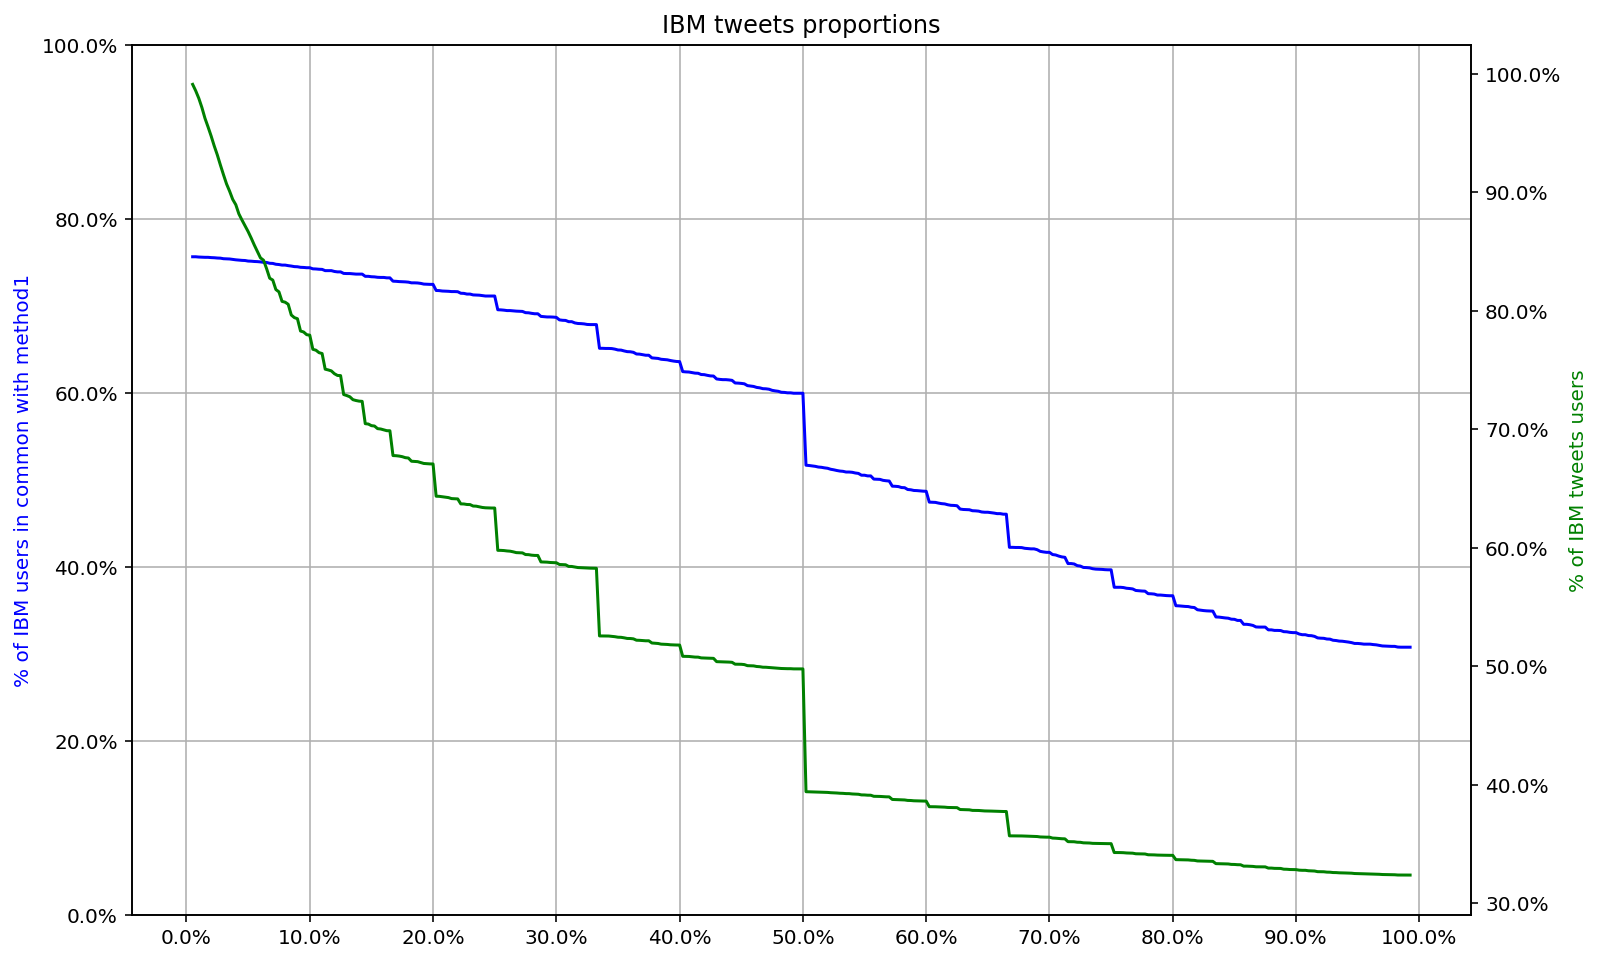

In [5]:
"""
Plot different choices of IBM tweets proportion affect the common users identified with 'description' field based method
"""
if 0 == 1:
    '''
    Prepare data
    '''
    ibm_tweets_prop_lst = np.arange(0.005, 0.995, 0.0025)
    
    cmm_ibm_user_pct_lst = []
    total_users_pct_lst = []
    
    data_lst = []
    with open(user_tw_ibmtw_num_lst_pkl, 'rb') as f:
        data_lst = pickle.load(f)
        
    df_user_nt = pd.DataFrame(data=data_lst,
                              columns=['user_id', 'tweets_num', 'ibm_tweets_num'], # explicitly pass in names of columns
                              dtype=int)

    # compute the proportion of IBM tweets
    df_user_nt['ibm_tweets_prop'] = df_user_nt['ibm_tweets_num'] / df_user_nt['tweets_num']
    
    user_nt_ibm_desc_ids_lst = []
    with open(USER_NT_IBM_DESC_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_desc_ids_lst = pickle.load(f)

    user_nt_ibm_tw_prop_1_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_1_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_1_ids_lst = pickle.load(f)

    
    for ibm_tweets_prop in ibm_tweets_prop_lst:
        
        user_nt_ibm_tw_num = len(user_nt_ibm_tw_prop_1_ids_lst)
        
        select_cond = df_user_nt['ibm_tweets_prop'] > ibm_tweets_prop
        df_tmp = df_user_nt[select_cond]
        
        tmp_user_ids_set = set(df_tmp['user_id'])
        cmm_ibm_user_pct = len(set(user_nt_ibm_desc_ids_lst).intersection(tmp_user_ids_set)) / len(user_nt_ibm_desc_ids_lst)
        cmm_ibm_user_pct_lst.append(cmm_ibm_user_pct)
        
        row_n = df_tmp.shape[0] # number of users identified
        total_users_pct = row_n / user_nt_ibm_tw_num
        total_users_pct_lst.append(total_users_pct)
    
    '''
    Plot
    '''
    fig, ax1 = plt.subplots()
    fig.set_size_inches((12,8))
    ax1.set_title('IBM tweets proportions')
    
    X = ibm_tweets_prop_lst
    Y1 = cmm_ibm_user_pct_lst
    ax1.plot(X, Y1, 'b-')
    ax1.set_ylabel("% of IBM users in common with method1", color='blue')
    ax1.set_ylim(0, 1)
    ax1.set_xticks(np.arange(0, 1.1, 0.1))
    X_vals = ax1.get_xticks()
    ax1.set_xticklabels(['{:.1%}'.format(X_val) for X_val in X_vals])
    ax1.grid()
    
    Y1_vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:.1%}'.format(Y1_val) for Y1_val in Y1_vals])
    

    ax2 = ax1.twinx()
    Y2 = total_users_pct_lst
    ax2.plot(X, Y2, 'g-')
    ax2.set_ylabel("% of IBM tweets users", color='g')
#     ax2.set_ylim(0, 0.1)
    Y2_vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:.1%}'.format(Y2_val) for Y2_val in Y2_vals])
    
    '''
    Save figure
    '''

## Check accounts @Natasha_D_G and @jameskobielus

While by using method_1, we can identify all users have keyword 'ibm' in their description field as affiliated with IBM, method_1 is limited that not all users would explicitly express their affiliation with IBM in their description field.  
So, the users identified by method_1 should be a subset of actual users affiliated with IBM. In other words, there are more users affiliated with IBM.
The idea we use here is that, if a person frequently mention keyword 'ibm' in tweets, he or she is highly likely affiliated with IBM. We use the proportion of tweets with keyword 'ibm' to identify these users. 

In [20]:
if 1 == 1:
    screen_name_1 = 'Natasha_D_G'
    screen_name_2 = 'jameskobielus'
    
    id_1 = 39413322
    id_2 = 14072398
            
    user_nt_ibm_tw_prop_1_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_1_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_1_ids_lst = pickle.load(f)
    
    user_nt_ibm_tw_prop_2_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_2_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_2_ids_lst = pickle.load(f) 

    user_nt_ibm_tw_prop_3_ids_lst = []
    with open(USER_NT_IBM_TW_PROP_3_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_tw_prop_3_ids_lst = pickle.load(f) 

    
    print('User {} exists in M2_1 IBM-user set? {}'.format(screen_name_1, id_1 in set(user_nt_ibm_tw_prop_1_ids_lst)))
    print('User {} exists in M2_2 IBM-user set? {}'.format(screen_name_1, id_1 in set(user_nt_ibm_tw_prop_2_ids_lst)))
    print('User {} exists in M2_3 IBM-user set? {}'.format(screen_name_1, id_1 in set(user_nt_ibm_tw_prop_3_ids_lst)))
    
    print('User {} exists in M2_1 IBM-user set? {}'.format(screen_name_2, id_2 in set(user_nt_ibm_tw_prop_1_ids_lst)))
    print('User {} exists in M2_2 IBM-user set? {}'.format(screen_name_2, id_2 in set(user_nt_ibm_tw_prop_2_ids_lst)))
    print('User {} exists in M2_3 IBM-user set? {}'.format(screen_name_2, id_2 in set(user_nt_ibm_tw_prop_3_ids_lst)))

User Natasha_D_G exists in M2_1 IBM-user set? True
User Natasha_D_G exists in M2_2 IBM-user set? True
User Natasha_D_G exists in M2_3 IBM-user set? False
User jameskobielus exists in M2_1 IBM-user set? True
User jameskobielus exists in M2_2 IBM-user set? True
User jameskobielus exists in M2_3 IBM-user set? False


Since @jameskobielus (James Kobielus) is not identified as IBM-user by our method_2, we check the tweets we captured for him.

In [21]:
"""
How many tweets we have in our database authored by @jameskobielus?
"""
tw_nt_txt_ibm_tag_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_TXT_IBM_TAG_COL)
jameskobielus_nt_num = tw_nt_txt_ibm_tag_col.count(filter={'user_id': id_2})
jameskobielus_ibm_nt_num = tw_nt_txt_ibm_tag_col.count(filter={'user_id': id_2, 'X_0': True})
print('{} native tweets we have for user {}'.format(jameskobielus_nt_num, screen_name_2))
print('{} native IBM tweets we have for user {}'.format(jameskobielus_ibm_nt_num, screen_name_2))

MongoDB on localhost:27017/tweets_ek-2.tw_nt_txt_ibm_tag connected successfully!
156 native tweets we have for user jameskobielus
17 native IBM tweets we have for user jameskobielus


In [29]:
"""
Check the content of these tweets
"""
cursor = updated_col.find(filter={'user.id': id_2}, projection={'_id':0, 'id': 1, 'text': 1})
count = 0
for doc in cursor:
    count += 1
    tweet_id = doc['id']
    tweet_text = doc['text']
    print('{}. ({})'.format(count, tweet_id))
    print(tweet_text)

1. (838756446363865089)
"Making sense of machine learning" (https://t.co/BGcmgG5MX8) JK--Eric Knorr parses definitions correctly: AI v. ML v. neural nets v. etc
2. (838759087387062272)
"120 Machine Learning business ideas" (https://t.co/NagS8tJOdc) JK--Substitute "big data analytics" for "ML," &amp; this is so 4 years ago
3. (838759808522153984)
"How to Generate Art - Intro to Deep Learning" (https://t.co/qPcVmEZV0q) JK--Computational artistry era awaits its Da Vinci.
4. (838763534418731008)
#Watson https://t.co/uQItFIwqBm https://t.co/2iV7XVrXGr
5. (838763654501707776)
#SecurityIntelligence #Watson https://t.co/PPjWIQfiAT https://t.co/O2PSZO82GB
6. (839160498595692544)
"Attention and Augmented Recurrent Neural Networks" (https://t.co/Z7jiq0CSVq) JK--Great dissection of key advances in this core DL approach
7. (839161477890191365)
"Davos 2016 - The State of Artificial Intelligence" (https://t.co/QfKpivHZT7) JK--When geekly topics consume world mover/shakers, watch out!
8. (839163344284

After manully checking all his tweets, 9 tweets were found including 'ibm' keyword.

# Notes